In [143]:
from google.cloud import language
import facebook
import requests
import random
import pandas as pd
import seaborn as sns
from IPython.core.display import display, HTML
from tqdm import tqdm
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from collections import Counter
from itertools import chain
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import numpy as np
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 100





gcl = language.Client()
with open("fbtoken", 'r') as tokfile:
    FBTOKEN = tokfile.read()
fb = facebook.GraphAPI(FBTOKEN, version='2.5')

# Sentiment Analysis

Of late there's been a lot of talk....


## Data Acquisition: Facebook API
### Posts:
We'll start by grabbing the last ~100 posts from Patagonia and REI. 

In [8]:
company_ids = {
    'patagonia':'97830335456',
    'rei':'9062006483'
}

In [9]:
company_posts = dict.fromkeys(company_ids.keys(), [])
for name in company_ids:
    posts = fb.get_connections(company_ids[name], 'posts')
    count = 0
    while count < 10:
        try:

            company_posts[name] = company_posts[name] + posts['data']
            # Attempt to make a request to the next page of data, if it exists.
            posts = requests.get(posts['paging']['next']).json()
            count += 1
        except KeyError as e:
            print(e)
            # When there are no more pages (['paging']['next']), break from the
            # loop and end the script.
            break

In [10]:
all_posts = None
for company in company_posts:
    print(company)
    tmp = pd.DataFrame(company_posts[company]).set_index('id')
    tmp['company'] = company
    if all_posts is None:
        all_posts = tmp
    else:
        all_posts = pd.concat([all_posts, tmp])
    
print("Total posts:", len(all_posts))
all_posts.sample(15)


rei
patagonia
Total posts: 500


,created_time,message,story,company
id,,,,
9062006483_10153762144931484,2015-12-09T22:00:08+0000,We clock in to powder. It's time to go to work...,NaN,rei
9062006483_10155294843351484,2017-05-12T22:05:00+0000,Apply now if your nonprofit helps get girls & ...,NaN,rei
97830335456_10158843155485457,2017-05-19T17:30:06+0000,Looking back on the largest land donation in h...,NaN,patagonia
9062006483_10151313090376484,2012-12-24T20:00:02+0000,A collection of gems that he is sure to love. ...,NaN,rei
97830335456_10158803055900457,2017-05-11T15:58:32+0000,Alex Megos taking a lil off the sides. Squamis...,NaN,patagonia
97830335456_10158978896540457,2017-06-13T19:15:04+0000,Looking deeper into nature’s color palette for...,NaN,patagonia
97830335456_10158770918700457,2017-05-05T01:00:50+0000,"""People say that Ueli was gifted, that his abi...",NaN,patagonia
9062006483_10155341500016484,2017-05-25T21:00:48+0000,Who else is starting the weekend early? Share ...,NaN,rei
9062006483_10152893339196484,2014-12-10T00:00:11+0000,"Celebrating our #givestoke contest winner, Lau...",NaN,rei



#### Post Examples
A random post from REI:

In [11]:
def show_post(longid):
    FB_EMBED = '<iframe src="https://www.facebook.com/plugins/post.php?href=https%3A%2F%2Fwww.facebook.com%2F{}%2Fposts%2F{}&width=500&show_text=true&height=591" width="500" height="591" style="border:none;overflow:hidden" scrolling="no" frameborder="0" allowTransparency="true"></iframe>'
    pageid, postid = longid.split("_")
    display(HTML(FB_EMBED.format(pageid, postid)))

post = random.sample(company_posts['rei'], 1)[0]
print(post)
show_post(post['id'])


{'id': '9062006483_10153809936826484', 'created_time': '2015-12-31T12:00:01+0000', 'message': 'Our New Year’s resolution—to share the goodness of a life outdoors with more people. We’d love your help! Tag who you’ll introduce to a new outdoor activity in 2016. And don’t forget to tell us about your adventure and post your photos with #OptOutside. Cheers!'}


And Patagonia: 

In [12]:
post = random.sample(company_posts['patagonia'], 1)[0]
print(post)
show_post(post['id'])

{'id': '97830335456_10158949496725457', 'created_time': '2017-06-08T17:22:05+0000', 'message': '“When I swam from the United States to Russia, I crossed the International Date Line—so I swam from the present to the future.” – Lynne Cox from #Fishpeople\n\nOn iTunes July 11, 2017, see the full trailer: http://pat.ag/TheFishpeople'}


---
### Comment Acquisition
*So*, we've got **{{len(company_posts['rei'])}} posts** for REI and **{{len(company_posts['patagonia'])}} posts** for Patagonia to look at. Let's take a random sample of 100 from each and see what the comment statistics look like.

First, we download the comments for those 100 each. 

In [13]:
comments = pd.DataFrame()
SAMPLE_SIZE = 100
for company, posts in all_posts.groupby("company"):
    print(company)
    samp = posts.sample(n=SAMPLE_SIZE)
    print(len(samp))
    for int,post in samp.iterrows():
        thisPostComments = pd.DataFrame(fb.request(post.name+'/comments', args={'limit':5000})['data'])
        thisPostComments['company'] = company
        thisPostComments['post_id'] = post.name
        comments = pd.concat([comments, thisPostComments])
        
        

patagonia
100
rei
100


#### Comment Examples:
Let's take a look at a couple random comments (here, the comment is in **bold** above the post it's on):

In [148]:
for i in range(5):
    randComment = comments.sample(n=1)
    display(HTML("<b>"+randComment['message'].values[0]+"</b> <i> "+randComment['company'].values[0]+" </i>"))
    show_post(randComment['post_id'].values[0])


Excellent, things seem to be working. Let's do a little more visualization.

## Comment Visualization.
Here we'll just do a word count plot to try out this analysis. 

We must remove stop words!

patagonia
rei


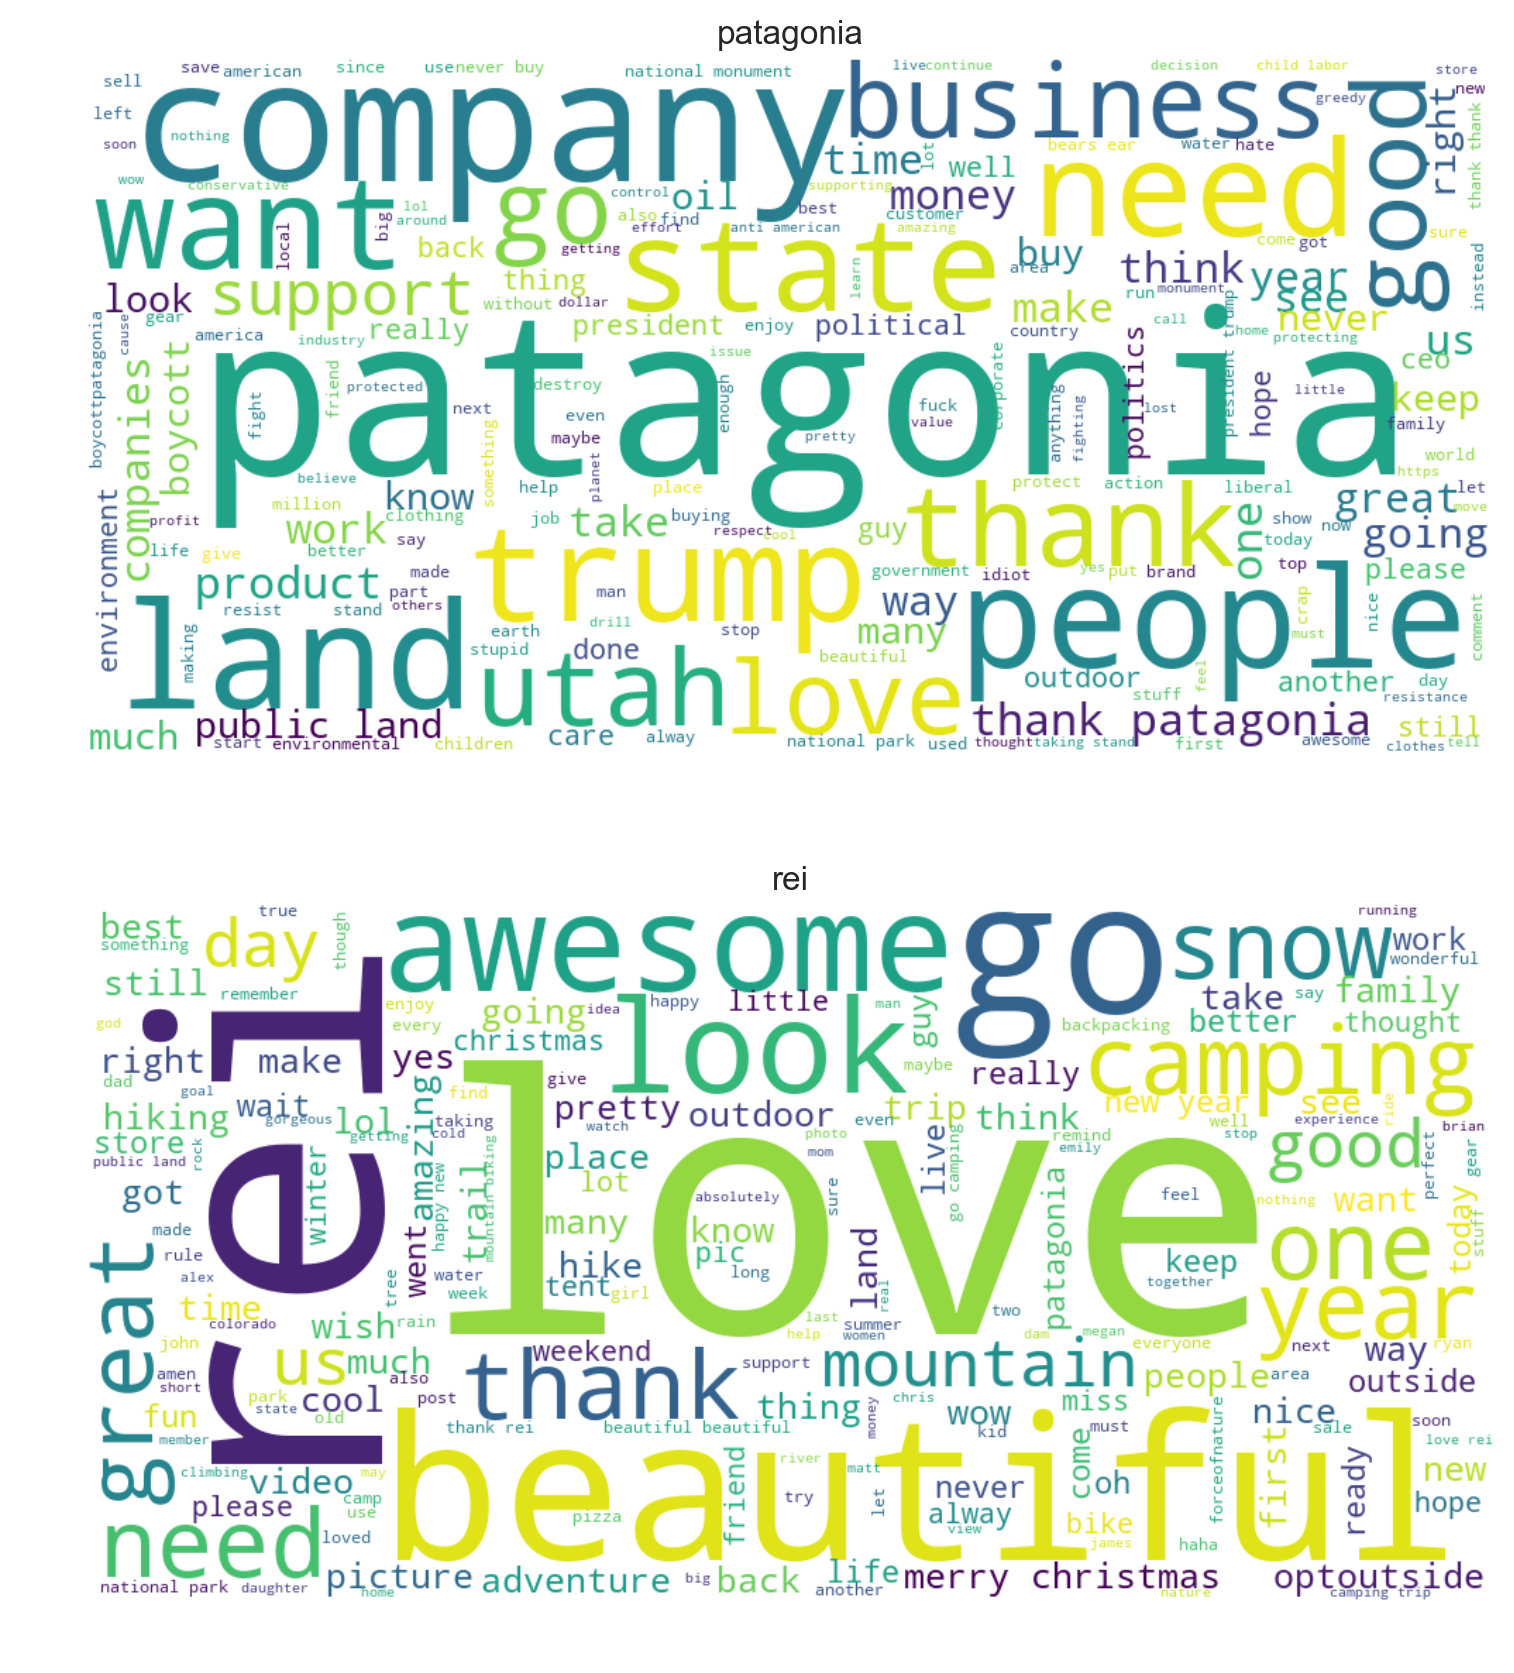

In [147]:
STOP_WORDS = stopwords.words('english')
fig, ax = plt.subplots(len(company_ids))
companyIdx = 0
for company, messages in comments.groupby('company')['message']:
    print(company)
    companyRow = ax[companyIdx]
    companyIdx += 1
    counter = Counter()
    allwords = list(chain.from_iterable(messages.str.lower().str.split()))
    
    filtered_words = [word for word in allwords if word not in STOP_WORDS]

    names, counts = zip(*Counter(filtered_words).most_common(10))
    
    wc = WordCloud(background_color='white', scale=2.5)
    wcloud = wc.generate(" ".join(filtered_words))
    companyRow.imshow(wcloud, interpolation='bilinear')
    companyRow.set_title(company)
    companyRow.axis('off')
    #sns.barplot(names, counts)
    #plt.title(company)
    #plt.show()
    
    


### Comments containing Certain Words

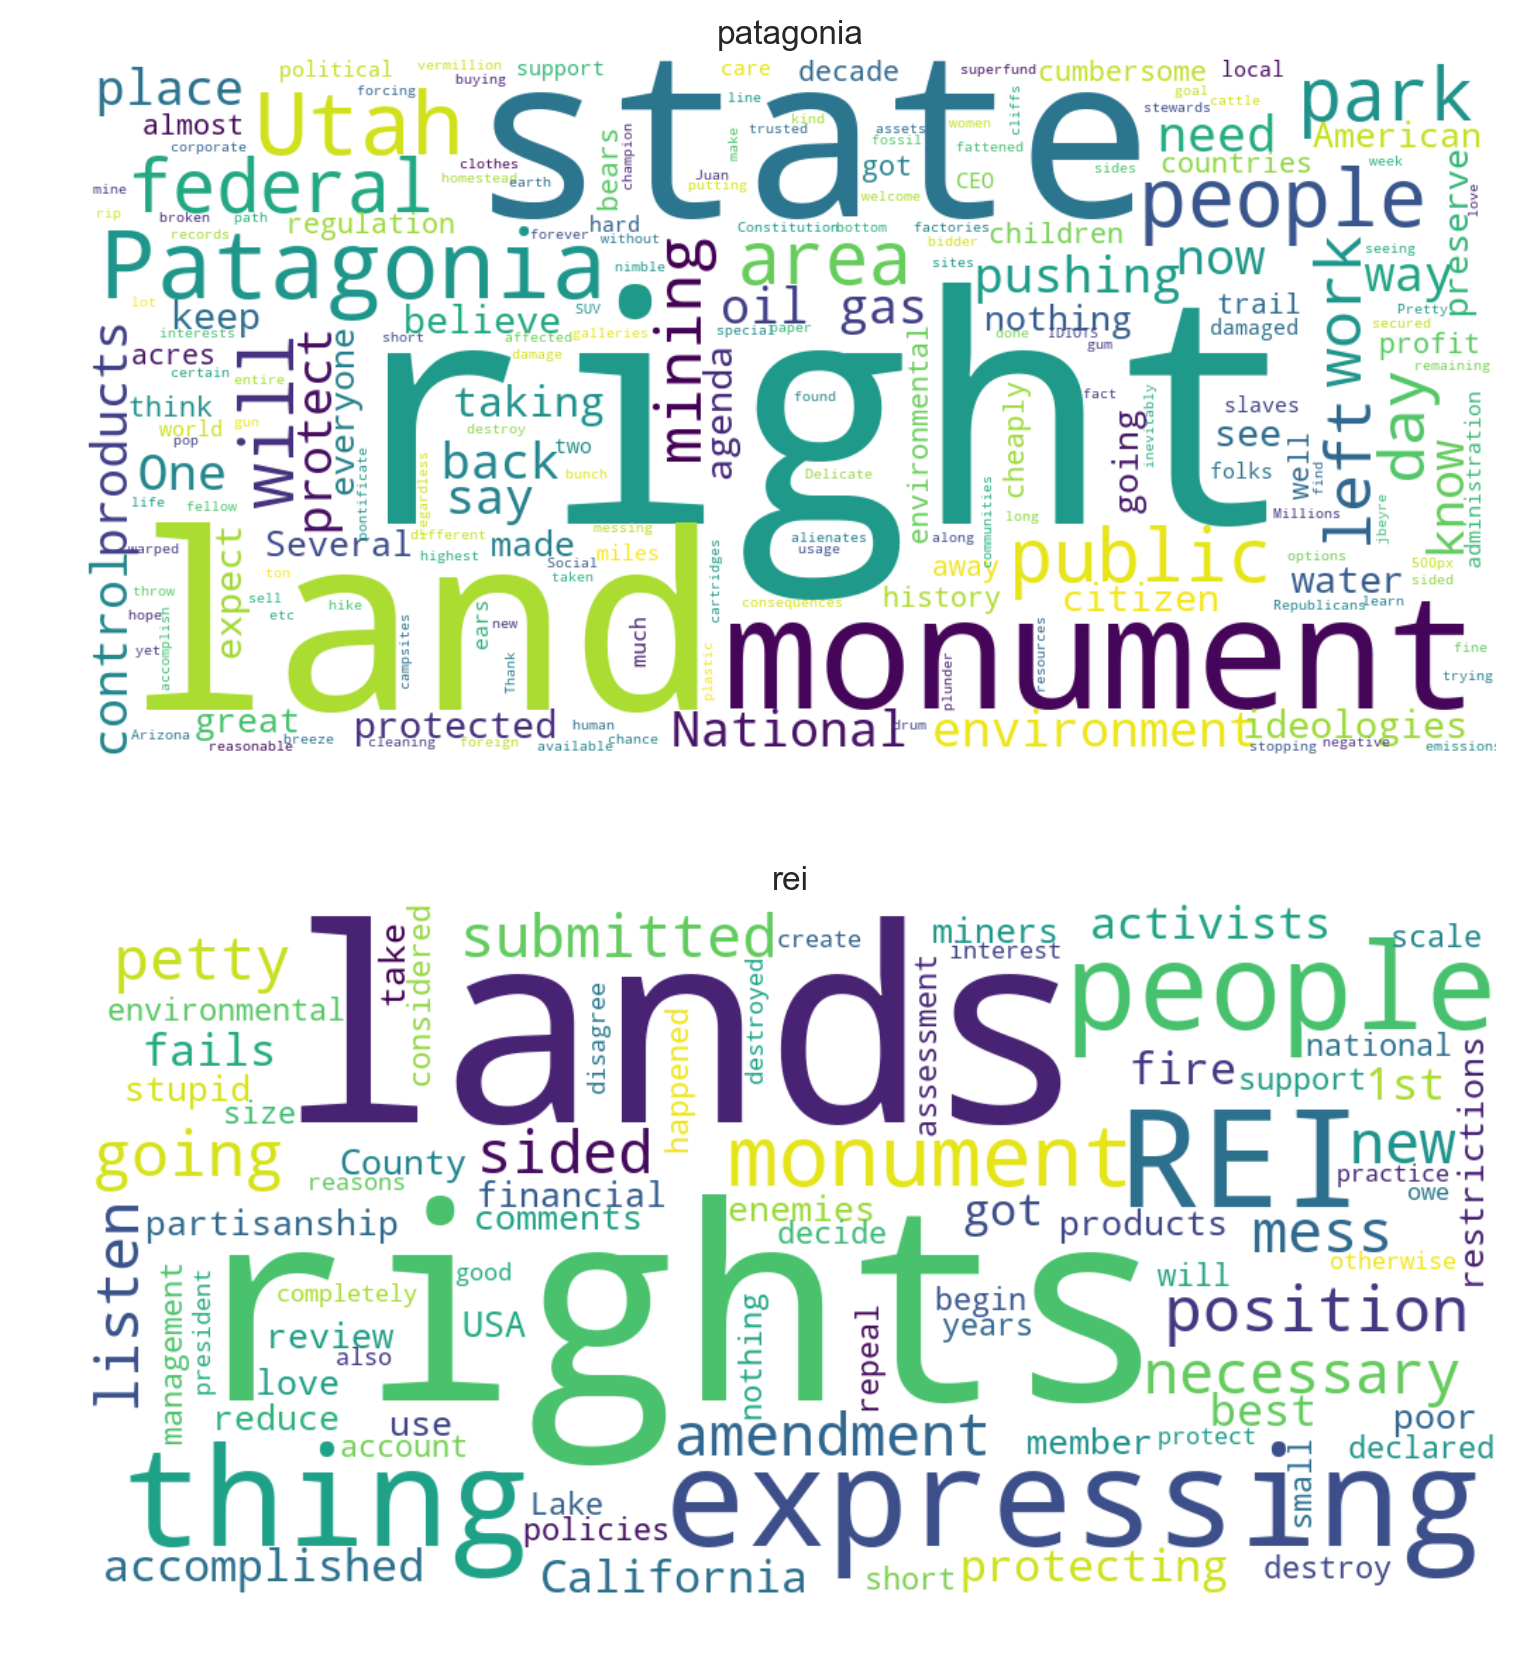

In [167]:

fig, ax = plt.subplots(len(company_ids))
companyIdx = 0
for company, messages in comments.groupby('company')['message']:
    filtered_words = messages[messages.str.contains('rights')]
    companyRow = ax[companyIdx]
    companyIdx += 1
    wc = WordCloud(background_color='white', scale=2.5)
    wcloud = wc.generate(" ".join(filtered_words))
    companyRow.imshow(wcloud, interpolation='bilinear')
    companyRow.set_title(company)
    companyRow.axis('off')



    
